In [ ]:
import os
os.chdir(r'path')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from torch.autograd import Variable
import os
import csv

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Data = scipy.io.loadmat('Data4.mat')
x = torch.tensor(Data['X'], dtype = torch.float32).to(device)
t = torch.tensor(Data['T'], dtype = torch.float32).to(device)
y = torch.tensor(Data['U'], dtype = torch.float32).to(device)

x = x[:,:,None]
t = t[:,:,None]
y = y[:,:,None]

x_tbc = x[:,0:1,:]
t_tbc = t[:,0:1,:]
y_tbc = y[:,0:1,:]

x_pde = x[:,1:,:]
t_pde = t[:,1:,:]
y_pde = y[:,1:,:]

In [ ]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_pde, t_pde, y_pde), batch_size=64, shuffle=True)

In [ ]:
# Physics parameters
m = 1
c = 1
EA = 4
L = 1

In [ ]:
class MLP_siren(nn.Module):
    def __init__(self,ips,width,layers,omega):
        super().__init__()
        osc = np.sqrt(6.0/width)
        self.input_layer = nn.Linear(ips,width)
        self.input_layer.weight.data.uniform_(-omega,omega)
        self.hidden_layers = nn.ModuleList([])
        self.output_layer = nn.Linear(width,1)
        self.output_layer.weight.data.uniform_(-osc,osc)
        for i in range(layers):
          self.linear_layer = nn.Linear(width,width)
          self.linear_layer.weight.data.uniform_(-osc,osc)
          self.hidden_layers.append(self.linear_layer)
        self.layers = layers

    def forward(self, x): # F.gelu
        layer_out = torch.sin(self.input_layer(x))
        for i in range(self.layers):
            layer_out = torch.sin(self.hidden_layers[i](layer_out))
        layer_out = self.output_layer(layer_out)
        return layer_out

class Finite_PINN(nn.Module):
    def __init__(self, width, layers, omega, basisnumber):
        super(Finite_PINN, self).__init__()
        self.Sirens = MLP_siren(1+basisnumber,width,layers,omega)
        self.k = 2 ** torch.arange(basisnumber)[None,None,:].to(device)
        self.basisnumber = basisnumber

    def forward(self, x, t):
        t = t
        x = torch.cos((x-1) * torch.pi/2 * self.k) * (self.basisnumber)**(-2)
        input = torch.cat((x,t),dim=2)
        y = self.Sirens(input) * t**2
        return y


In [ ]:
model = Finite_PINN(width = 64, layers = 6, omega=30, basisnumber=4).to(device)

optimizer0 = torch.optim.Adam(model.parameters(), lr=5e-4)
num_epochs = 1000

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    bc_mse,pde_mse = 0,0
    ne = 0

    for xi, ti, yi in train_loader:
        ne += 1
        optimizer0.zero_grad()

        # PDE
        xi, ti, yi = xi.cuda(), ti.cuda(), yi.cuda()
        xi.requires_grad = True
        ti.requires_grad = True
        out = model(xi, ti)

        dout_dx = autograd.grad(out,xi,torch.ones_like(out),retain_graph=True,create_graph=True)[0]
        dout_dx_dx = autograd.grad(dout_dx,xi,torch.ones_like(dout_dx),retain_graph=True,create_graph=True)[0]
        dout_dt = autograd.grad(out,ti,torch.ones_like(out),retain_graph=True,create_graph=True)[0]
        dout_dt_dt = autograd.grad(dout_dt,ti,torch.ones_like(dout_dt),retain_graph=True,create_graph=True)[0]

        pde = m*dout_dt_dt + c*dout_dt - EA*dout_dx_dx
        pde_loss = F.mse_loss(pde, torch.zeros_like(pde)) * 1e-6

        # TBC
        out_tbc = model(x_tbc,t_tbc)
        tbc_loss = F.mse_loss(out_tbc, y_tbc)

        Loss = tbc_loss + pde_loss
        Loss.backward()
        optimizer0.step()

        pde_mse += pde_loss.item()

    bc_mse = tbc_loss.item()
    pde_mse /= ne

    t2 = default_timer()
    print(f'Epoch:{ep+1}, Time:{t2-t1:.3g}s, BC Loss:{bc_mse:.3e}, PDE Loss:{pde_mse:.3e}')

Epoch:1, Time:1.75s, BC Loss:9.471e-02, PDE Loss:1.018e+00
Epoch:2, Time:1.46s, BC Loss:9.212e-02, PDE Loss:1.446e-01
Epoch:3, Time:1.46s, BC Loss:9.025e-02, PDE Loss:7.143e-02
Epoch:4, Time:1.46s, BC Loss:8.842e-02, PDE Loss:4.696e-02
Epoch:5, Time:1.45s, BC Loss:8.666e-02, PDE Loss:3.410e-02
Epoch:6, Time:1.46s, BC Loss:8.492e-02, PDE Loss:2.636e-02
Epoch:7, Time:1.45s, BC Loss:8.315e-02, PDE Loss:2.130e-02
Epoch:8, Time:1.47s, BC Loss:8.135e-02, PDE Loss:1.766e-02
Epoch:9, Time:1.5s, BC Loss:7.948e-02, PDE Loss:1.512e-02
Epoch:10, Time:1.48s, BC Loss:7.760e-02, PDE Loss:1.322e-02
Epoch:11, Time:1.46s, BC Loss:7.568e-02, PDE Loss:1.192e-02
Epoch:12, Time:1.45s, BC Loss:7.378e-02, PDE Loss:1.091e-02
Epoch:13, Time:1.44s, BC Loss:7.190e-02, PDE Loss:1.019e-02
Epoch:14, Time:1.44s, BC Loss:7.004e-02, PDE Loss:9.676e-03
Epoch:15, Time:1.47s, BC Loss:6.818e-02, PDE Loss:9.263e-03
Epoch:16, Time:1.45s, BC Loss:6.635e-02, PDE Loss:9.045e-03
Epoch:17, Time:1.45s, BC Loss:6.455e-02, PDE Loss:

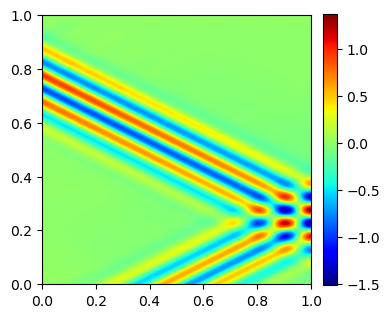

In [ ]:
out = model(x,t)
out = out.squeeze().detach().cpu()
plt.figure(figsize=(4, 4))
plt.imshow(out, extent=[0, 1, 0, 1], cmap='jet')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()